In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
PATH = 'data'
fileList_ori = os.listdir(PATH)
labels = {'Alanine':0, 'glycine':1}


fileList = []
for i in range(len(fileList_ori)):
    for j in range(100):
        fileList.append(fileList_ori[i])

In [18]:
train_num = len(fileList)

input_x = 32
input_y = 32 
input_z = 32

x_train = np.zeros((train_num, input_x, input_y, input_z, 1))
y_train = np.zeros((train_num, 2))

for j in range(len(fileList)):
    
    print "{}/{} - {} loaded".format(j, len(fileList), PATH+'/'+fileList[j])
    
    dfs = pd.read_excel(PATH+'/'+fileList[j], sheet_name='Sheet1')
    index = dfs.columns
    label = fileList[j].split('-')
    #print label

    tmp = []
    for i in range(len(dfs)):
        tmp.append([dfs[index[0]][i], dfs[index[1]][i], dfs[index[2]][i]])
    tmp = np.asarray(tmp)

    xData = tmp[:,0]/max(tmp[:,0]) * (input_x-1)
    yData = tmp[:,1]/max(tmp[:,1]) * (input_y-1)
    zData = tmp[:,2]/max(tmp[:,2]) * (input_z-1)

    for i in range(len(xData)):
        #print ('x:{}, y:{}, z:{}'.format(int(np.trunc(xData[i])), int(np.trunc(yData[i])), int(np.trunc(zData[i]))))
        x_train[j, int(np.trunc(xData[i])), int(np.trunc(yData[i])), int(np.trunc(zData[i])), 0] = 1
        y_train[j, labels[label[0]]] = 1

0/200 - data/glycine loaded


IOError: [Errno 21] Is a directory: 'data/glycine'

In [4]:
index = np.arange(len(fileList))
np.random.shuffle(index)

x_train_shuffle = np.zeros((train_num, input_x, input_y, input_z, 1))
y_train_shuffle = np.zeros((train_num, 2))
for i in range(len(index)):
    x_train_shuffle[i] = x_train[index[i]]
    y_train_shuffle[i] = y_train[index[i]]

In [5]:
test_num = len(fileList_ori)

x_test = np.zeros((test_num, input_x, input_y, input_z, 1))
y_test = np.zeros((test_num, 2))

for j in range(len(fileList_ori)):
    
    print "{}/{} - {} loaded".format(j, len(fileList_ori), PATH+'/'+fileList_ori[j])
        
    dfs = pd.read_excel(PATH+'/'+fileList_ori[j], sheet_name='Sheet1')
    index = dfs.columns
    label = fileList_ori[j].split('-')
    #print label

    tmp = []
    for i in range(len(dfs)):
        tmp.append([dfs[index[0]][i], dfs[index[1]][i], dfs[index[2]][i]])
    tmp = np.asarray(tmp)

    xData = tmp[:,0]/max(tmp[:,0]) * (input_x-1)
    yData = tmp[:,1]/max(tmp[:,1]) * (input_y-1)
    zData = tmp[:,2]/max(tmp[:,2]) * (input_z-1)

    for i in range(len(xData)):
        #print ('x:{}, y:{}, z:{}'.format(int(np.trunc(xData[i])), int(np.trunc(yData[i])), int(np.trunc(zData[i]))))
        x_test[j, int(np.trunc(xData[i])), int(np.trunc(yData[i])), int(np.trunc(zData[i])), 0] = 1
        y_test[j, labels[label[0]]] = 1

0/4 - data/Alanine-sample.xlsx loaded
1/4 - data/Alanine-standard.xlsx loaded
2/4 - data/glycine-standard.xlsx loaded
3/4 - data/glycine-sample.xlsx loaded


In [6]:
nb_filters = [32, 32]
nb_conv = [3, 3]
nb_pool = [2, 2]
nb_classes = 2

model = Sequential()
model.add(Conv3D(nb_filters[0], (nb_conv[0], nb_conv[0], nb_conv[0]), input_shape=(input_x, input_y, input_z, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 30, 30, 32)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 15, 32)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 108000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               13824128  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [7]:
nb_epoch = 2
batch_size = 32

hist = model.fit( x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs = nb_epoch, shuffle=True)


Epoch 1/2
400/400 [==============================] - 34s 86ms/step - loss: 0.3031 - mse: 0.0916 - accuracy: 0.8850
Epoch 2/2
400/400 [==============================] - 34s 84ms/step - loss: 0.0252 - mse: 0.0016 - accuracy: 1.0000


In [11]:
score = model.evaluate(x_test, y_test, batch_size=batch_size) #show_accuracy=True
classes= model.predict_classes(x_test)
print('**********************************************')
print('Test score:', score)
print('History', hist.history)
print('**********************************************')
for i in range(len(classes)):
    print('Label: {}, Predicted: {}'.format(list(labels.keys())[list(labels.values()).index(np.argmax(y_test[i]))], 
                                            list(labels.keys())[list(labels.values()).index(classes[i])]))

4/4 [==============================] - 0s 10ms/step
**********************************************
('Test score:', [0.005352429114282131, 3.5541852412279695e-05, 1.0])
('History', {'loss': [0.3030964532494545, 0.025161441043019296], 'mse': [0.09164632, 0.0015900752], 'accuracy': [0.885, 1.0]})
**********************************************
Label: Alanine, Predicted: Alanine
Label: Alanine, Predicted: Alanine
Label: glycine, Predicted: glycine
Label: glycine, Predicted: glycine


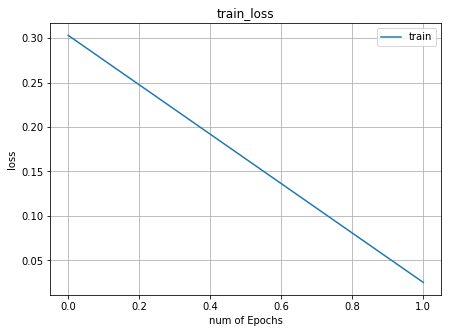

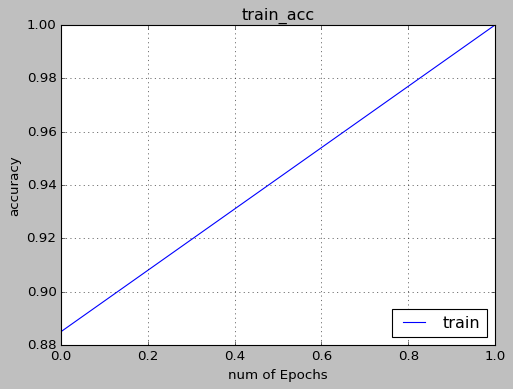

In [12]:
# Plot the results
train_loss=hist.history['loss']
#val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
#val_acc=hist.history['val_acc']

plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
#plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss') # vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
#plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc') # vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])